Variables:

- flag superficie imputada
- 

In [431]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from malbecs.modeling import train as tr

wine_path = "../../data/final/wine_final.csv"
eto_path = "../../data/final/eto_final.csv"
meteo_path = "../../data/final/meteo_final.csv"

def show_feat_imps(feat_imp, feat_names):
    pd.DataFrame(
        feat_imp,
        index=feat_names,
        columns=["feat_imp"]
    ).sort_values("feat_imp")[-50:].plot(kind='barh', figsize=(6, 15))


In [432]:

data = tr.load_final_data(
    wine_path=wine_path,
    eto_path=eto_path,
    meteo_path=meteo_path
)

with open("../../data/final/meteo_features.txt", "r", encoding="utf-8") as f:
    meteo_cols = f.read().split("\n")

with open("../../data/final/eto_features.txt", "r") as f:
    eto_cols = f.read().split("\n")

with open("../../data/final/wine_features.txt", "r") as f:
    wine_cols = f.read().split("\n")


In [52]:
data_train = tr.filter_camp(data.copy(), min_camp=15, max_camp=21)

data_final = tr.filter_camp(data, min_camp=22, max_camp=22)

train, test = tr.train_test_split(data_train, test_camp=21)

X, y = tr.xy_split(data_train)

cat_cols = [
    'id_finca',
    'id_zona',
    'id_estacion',
    'variedad',
    "modo",
    "tipo",
    "color",
    "prod_shift1_gt_shift2"
]
num_cols = [col for col in X.columns if col not in cat_cols]

X[cat_cols] = X[cat_cols].astype('category')

X_train, y_train = tr.xy_split(train)
X_test, y_test = tr.xy_split(test)
X_final, y_final = tr.xy_split(data_final)

train_idxs, test_idxs = tr.CampKFold.get_train_test(
    X['campaña'], from_camp=19, to_camp=21
)

cv = tr.CampKFold(train_idxs, test_idxs)


In [132]:
[c for c in X.columns if "prod" in c]

['prod_shift1',
 'prod_shift2',
 'prod_shift1_gt_shift2',
 'prod_shift_max',
 'prod_shift_change',
 'prod_shift_avg',
 'prod_est_mean_change',
 'prod_he_shift1',
 'prod_he_shift2',
 'prod_he_shift_change',
 'prod_he_shift_avg',
 'prod_he_var_zone_mean_hist',
 'prod_he_var_zone_std_hist',
 'prod_he_var_mean_hist',
 'prod_he_var_std_hist',
 'prod_var_shift_1',
 'prod_var_shift_2',
 'prod_he_zone_mean',
 'prod_he_zone_std',
 'prod_he_var_mean',
 'prod_he_var_std',
 'prod_finca_shift_1',
 'prod_finca_shift_1.1']

In [53]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, HuberRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, StandardScaler
import pickle as pkl
from typing import List
import malbecs.modeling.transformers as mt

seed = 42

def get_base_model():

    model_num_cols = [
        'superficie',
        'prod_shift_max',
        'prod_shift_change',
        'prod_shift_avg',
    ]

    m = make_pipeline(
        make_column_transformer(

            (mt.BaseNEncoder(), ['id_finca']),

            (mt.TargetEncoder(), ['id_zona']),

            (OrdinalEncoder(handle_unknown='use_encoded_value',
             unknown_value=-1), ['id_estacion']),

            (mt.BaseNEncoder(), ['variedad']),

            (OrdinalEncoder(handle_unknown='use_encoded_value',
             unknown_value=-1), ['modo']),

            (KBinsDiscretizer(n_bins=2), ['altitud']),

            (StandardScaler(), model_num_cols),

            remainder='drop'
        ),
        RandomForestRegressor(
            random_state=seed,
            n_estimators=200,
            min_samples_leaf=4,
            n_jobs=-1,
            max_features='sqrt',
            max_samples=0.8
        )
    )
    return m


In [54]:
m = get_base_model()

In [55]:
from sklearn.model_selection import cross_validate
import numpy as np

res = cross_validate(
    estimator=m,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True
)


print("train: ", res['train_score'])
print("test: ", res['test_score'])
print(f"Train Mean RMSE: {np.mean(res.get('train_score'))}")
print(f"Test Mean RMSE: {np.mean(res.get('test_score'))}")


train:  [-4951.57528584 -4734.83647804 -4806.94380397]
test:  [-4752.63078656 -6727.57574147 -5397.83953568]
Train Mean RMSE: -4831.118522614094
Test Mean RMSE: -5626.015354570026


In [56]:
percip_cols = [c for c in eto_cols if "Precip" in c]
snow_cols = [c for c in eto_cols if "Snow" in c]
temp_day_cols = [c for c in eto_cols if "TemperatureLocalDay" in c]
temp_cols = [
    c for c in eto_cols if "TemperatureLocalAfter" in c or "TemperatureLocalOvern" in c]
evotrans_cols = [c for c in eto_cols if "Evapotranspiration" in c]
feelslike_cols = [c for c in eto_cols if "FeelsLikeLoca" in c]
irrad_cols = [c for c in eto_cols if "Irradiance" in c]
gust_cols = [c for c in eto_cols if "Gust" in c]
wind_cols = [c for c in eto_cols if "Wind" in c]
dewpoint_cols = [c for c in eto_cols if "Dewpoint" in c]
mslp_cols = [c for c in eto_cols if "MSLP" in c]
humid_cols = [c for c in eto_cols if "Humidity" in c]
uvindex_cols = [c for c in eto_cols if "UVIndex" in c]
visib_cols = [c for c in eto_cols if "Visibility" in c]


In [425]:
n_fincas = X['id_finca'].nunique()
top_fincas = X.id_finca.value_counts()[:int(0.8*n_fincas)].index.values.tolist()
X['id_finca_top'] = X['id_finca'].apply(lambda x: x if x in top_fincas else -1)

n_zonas = X['id_zona'].nunique()
top_zonas = X['id_zona'].value_counts()[:int(0.8*n_zonas)].index.values.tolist()
X['id_zona_top'] = X['id_zona'].apply(lambda x: x if x in top_zonas else -1)

n_var = X['variedad'].nunique()
top_variedad= X['variedad'].value_counts()[:int(0.8*n_var)].index.values.tolist()
X['variedad_top'] = X['variedad'].apply(
    lambda x: x if x in top_variedad else -1)


In [426]:
from sklearn.decomposition import PCA


def get_preprocesing():

    model_num_cols = [
        'superficie',
        # 'prod_shift1',
        # 'prod_shift2',
        'prod_shift_max',
        'prod_shift_change',
        'prod_shift_avg',
        # 'prod_he_shift1',
        # 'prod_he_shift2',
        # 'prod_he_shift_change',
        # 'prod_he_shift_avg',
        # 'prod_he_var_zone_mean_hist',
        # 'prod_he_var_zone_std_hist',
        # 'prod_he_var_mean_hist',
        # 'prod_he_var_std_hist',
        # 'prod_var_shift_1',
        # 'prod_var_shift_2',
        # 'prod_he_zone_mean',
        # 'prod_he_zone_std',
        # 'prod_he_var_mean',
        # 'prod_he_var_std',
    ]

    return make_column_transformer(

        # (mt.BaseNEncoder(), ['id_finca']),
        (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ['id_finca_top']),
         
        # (mt.TargetEncoder(), ['id_zona']),
        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['id_zona_top']),

        # (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['id_estacion']),

        # (mt.BaseNEncoder(), ['variedad']), 
        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['variedad_top']),

        (OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1), ['modo']),

        # (KBinsDiscretizer(n_bins=2), ['altitud']),

        (StandardScaler(), model_num_cols),
        
        # (StandardScaler(),temp_cols),
        # (make_pipeline(StandardScaler(),PCA(n_components=3, random_state=seed)), temp_cols),

        # (StandardScaler(),[c for c in percip_cols if 'Sum' in c]),
        # (make_pipeline(StandardScaler(),PCA(n_components=3, random_state=seed)),
        #      [c for c in percip_cols if 'Sum' in c]
        # ),
        # (StandardScaler(),[c for c in snow_cols if 'Sum' in c and ("1" in c or "2" in c)]),
        # (StandardScaler(), [c for c in gust_cols if 'Max' in c ]),
        # (make_pipeline(StandardScaler(),PCA(n_components=2, random_state=seed)), [c for c in gust_cols if 'Max' in c ]),
        # (StandardScaler(),[c for c in humid_cols if "Avg" in c]),
        # (make_pipeline(StandardScaler(),PCA(n_components=3, random_state=seed)), [c for c in humid_cols if "Avg" in c]),
        # (make_pipeline(StandardScaler(),PCA(n_components=3, random_state=seed)), uvindex_cols),
        # (make_pipeline(StandardScaler(),PCA(n_components=3, random_state=seed)), dewpoint_cols),
        # (make_pipeline(StandardScaler(),PCA(n_components=3, random_state=seed)), wind_cols),


        remainder='drop'
    )


In [429]:
from sklearn.ensemble import StackingRegressor

prep = get_preprocesing()
# model = LinearRegression()
# model = Lasso(random_state=seed)
# model = Ridge(random_state=seed)
# model = ElasticNet(random_state=seed)

model = RandomForestRegressor(
    random_state=seed,
    n_estimators=400,
    min_samples_leaf=4,
    n_jobs=-1,
    max_features='sqrt',
    max_samples=0.8
    # random_state=seed,
    # n_estimators=400,
    # min_samples_leaf=,
    # max_depth=8,
    # n_jobs=-1,
    # max_features=1.0,
    # max_samples=1.0
)


# model = StackingRegressor(
#     estimators=[(
#         f"rf_{i}",
#         RandomForestRegressor(
#             random_state=seed+i,
#             n_estimators=[300,200,200,80][i],
#             min_samples_leaf=[3,4,4,5][i],
#             n_jobs=-1,
#             max_features=['sqrt', 'sqrt', 'sqrt',0.5][i],
#             max_samples=0.8
#         ) 
#     ) for i in range(4)],
#     final_estimator = make_pipeline(StandardScaler(),Ridge()),
# )

# model = StackingRegressor(
#     estimators=[(
#         f"rf_{i}",
#         RandomForestRegressor(
#             random_state=seed+i,
#             n_estimators=200+i*10,
#             min_samples_leaf=4,
#             n_jobs=-1,
#             max_features='sqrt',
#             max_samples=0.9
#         )
#     ) for i in range(2)],
#     final_estimator=make_pipeline(StandardScaler(), LinearRegression()),
# )

m = make_pipeline(
    prep,
    model
)


In [430]:
res = cross_validate(
    estimator=m,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True
)


print("train: ", res['train_score'])
print("test: ", res['test_score'])
print(f"Train Mean RMSE: {np.mean(res.get('train_score'))}")
print(f"Test Mean RMSE: {np.mean(res.get('test_score'))}")

train:  [-4922.66903284 -4701.36243394 -4788.9920175 ]
test:  [-4885.78024517 -6739.48496851 -5447.14265018]
Train Mean RMSE: -4804.341161425672
Test Mean RMSE: -5690.8026212857


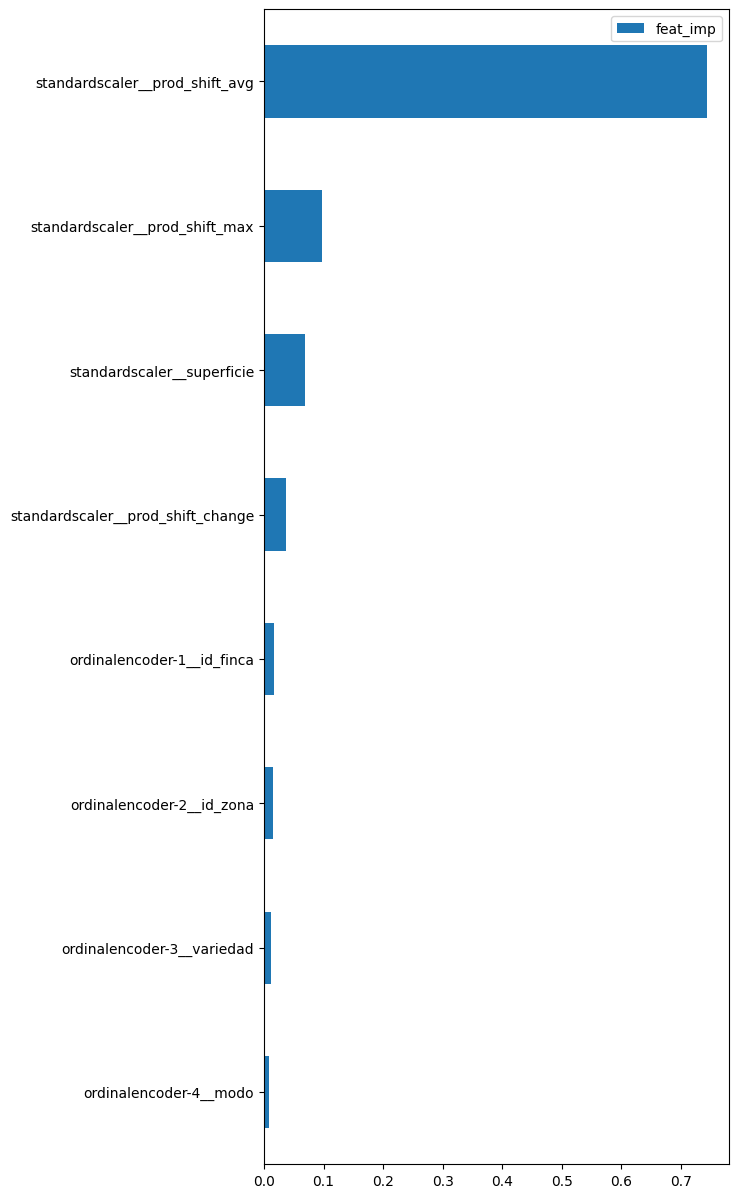

In [340]:
m.fit(X,y)
show_feat_imps(
    m[-1].feature_importances_,
    m[:-1].get_feature_names_out(),
)


In [154]:
from numpy import linspace
from sklearn.model_selection import GridSearchCV

param_grid = {
    'randomforestregressor__max_features': [0.8],
    'randomforestregressor__max_depth': [4, 5, 6],
    'randomforestregressor__n_estimators': [200, 300],
}
# param_grid = {
#     'lasso__alpha':linspace(150,160,10)
# }
# param_grid = {
#     'ridge__alpha': linspace(860, 870, 10)
# }
# param_grid = {
#     'elasticnet__alpha': linspace(0.1,1, 10),
#     'elasticnet__l1_ratio': [0.6,0.7,0.8]
# }

gsm = GridSearchCV(
    m,
    param_grid=param_grid,
    cv=cv,
    verbose=1,
    scoring=tr.rmse_scorer
)

gsm.fit(X,y)

print(gsm.best_params_)
print(gsm.best_score_)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
{'randomforestregressor__max_depth': 6, 'randomforestregressor__max_features': 0.8, 'randomforestregressor__n_estimators': 300}
-6097.578173380302


In [155]:
# m = gsm.best_estimator_
# y_pred = m.fit(X_train, y_train).predict(X_test)
# score_model(X_test, y_test, y_pred, sup_norm=False)
res = cross_validate(
    estimator=gsm.best_estimator_,
    X=X,
    y=y,
    cv=cv,
    n_jobs=-1,
    scoring=tr.rmse_scorer,
    return_train_score=True,
    return_estimator=True
)


print("train: ", res['train_score'])
print("test: ", res['test_score'])
print(f"Train Mean RMSE: {np.mean(res.get('train_score'))}")
print(f"Test Mean RMSE: {np.mean(res.get('test_score'))}")


train:  [-5189.94114412 -5050.66877177 -5279.32279521]
test:  [-5354.69578649 -7189.67580014 -5748.36293351]
Train Mean RMSE: -5173.3109037013855
Test Mean RMSE: -6097.578173380302
